[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [4]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [5]:
print(os.getenv("LANGSMITH_PROJECT"))

langchain-academy


In [6]:
import os
from dotenv import load_dotenv

# 指定 .env 文件路径
env_path = r'C:\GitRepo\translation-agent\langgraph_server\react-demo\.env'

# 加载 .env 文件
load_dotenv(dotenv_path=env_path)
print(f"The AZURE_OPENAI_ENDPOINT is: {os.getenv('AZURE_OPENAI_ENDPOINT')}")

# os.environ["LANGSMITH_PROJECT"] = "langchain-academy-02"

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)



The AZURE_OPENAI_ENDPOINT is: https://jz-fdpo-swn.openai.azure.com/


In [7]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def get_user_full_name(name: str) -> str:
    """get user's full name.

    Args:
        name: user's partial name.
    """
    
    # Check if the name starts with the letter 'J'
    if name.startswith('J'):
        return "Joey Zeng"
    else:
        return "Iris Zeng"




tools = [add, multiply, divide,get_user_full_name]

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [8]:
llm.invoke('hi, v0')

AIMessage(content='Hello! 😊 It seems like you\'re referring to "v0"—how can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 11, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BLWgzuPy0piQCBnAlfxVkgibJPDW4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 's

In [3]:
# LangChain Python also supports a context manager for tracing a specific block of code.
from langchain_core.tracers.context import tracing_v2_enabled
with tracing_v2_enabled():
  llm.invoke('hi,v2')

In [4]:

# You can configure a LangChainTracer instance to trace a specific invocation.
from langchain.callbacks.tracers import LangChainTracer

tracer = LangChainTracer()
llm.invoke('hi,v1', config={"callbacks": [tracer]})


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_b705f0c291', 'id': 'chatcmpl-BEDGnOaP0TIh5a9fEpxPixCuIPOos', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_cod

Let's create our LLM and prompt it with the overall desired agent behavior.

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

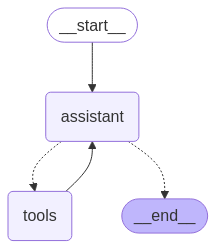

In [ ]:
# 手写版
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

#graph
builder = StateGraph(MessagesState)

#新增node
builder.add_node("assistant", assistant )
builder.add_node("tools", ToolNode(tools) )

#定义 edge 边
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

from IPython.display import Image, display
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png() ))


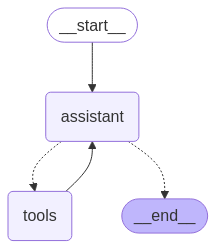

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="7*22+9-1=?")  ]
messages


[HumanMessage(content='7*22+9-1=?', additional_kwargs={}, response_metadata={})]

In [15]:
{"messages": messages}

{'messages': [HumanMessage(content='7*22+9-1=?', additional_kwargs={}, response_metadata={})]}

In [16]:
messages = react_graph.invoke(  {"messages": messages} )
messages

{'messages': [HumanMessage(content='7*22+9-1=?', additional_kwargs={}, response_metadata={}, id='877249d8-a9a6-4d9d-a036-72836206c345'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e6mvp5GXJplBnXdiF4cOoDjU', 'function': {'arguments': '{"a":7,"b":22}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 159, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BLX1W9YhL3JXuOa1UxF7XKeTMTWYA', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [21]:
messages['messages']

[HumanMessage(content='7*22+9-1=?', additional_kwargs={}, response_metadata={}, id='877249d8-a9a6-4d9d-a036-72836206c345'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e6mvp5GXJplBnXdiF4cOoDjU', 'function': {'arguments': '{"a":7,"b":22}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 159, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BLX1W9YhL3JXuOa1UxF7XKeTMTWYA', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'fi

In [18]:
messages['messages'][-1].pretty_print()

================================== Ai Message ==================================

The result of \( 7 \times 22 + 9 - 1 \) is 162.


In [19]:
for m in messages['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

The result of \( 7 \times 22 + 9 - 1 \) is 162.


In [20]:
for m in messages['messages']:
    # print(m)
    m.pretty_print()

================================ Human Message =================================

7*22+9-1=?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e6mvp5GXJplBnXdiF4cOoDjU)
 Call ID: call_e6mvp5GXJplBnXdiF4cOoDjU
  Args:
    a: 7
    b: 22
================================= Tool Message =================================
Name: multiply

154
================================== Ai Message ==================================
Tool Calls:
  add (call_ySC8he9sybPr1wjuIJB6Nrp2)
 Call ID: call_ySC8he9sybPr1wjuIJB6Nrp2
  Args:
    a: 154
    b: 9
================================= Tool Message =================================
Name: add

163
================================== Ai Message ==================================
Tool Calls:
  add (call_nAUxx2OwPXcLQixrwt2Y73AR)
 Call ID: call_nAUxx2OwPXcLQixrwt2Y73AR
  Args:
    a: 163
    b: -1
================================= Tool Message =================================
Name: add

162
============

In [22]:
messages = [HumanMessage(content="Kate的全名是什么")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Kate的全名是什么
================================== Ai Message ==================================
Tool Calls:
  get_user_full_name (call_itN2o9JSWW64B4fZ99yRYaM0)
 Call ID: call_itN2o9JSWW64B4fZ99yRYaM0
  Args:
    name: Kate
================================= Tool Message =================================
Name: get_user_full_name

Iris Zeng
================================== Ai Message ==================================

Kate的全名是Iris Zeng。


## LangSmith

We can look at traces in LangSmith.

In [24]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "LangChain-academy"
